In [253]:
from pathlib import Path
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import pickle
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

In [285]:
PWD = Path().cwd()
DATA = Path("../data")
IPS = DATA / "rnaseq_res_ips"
HIMORNA = DATA / "himorna_peaks"
FANTOM = DATA / "fantom_cat"
PREPROCESSING = Path("../preprocessing")
HIMORNA_INDEX = PREPROCESSING / "himorna_index"
IPS_INDEX = PREPROCESSING / "ips_deg_index"
MATRICES = PREPROCESSING / "matrices"
FISHER = PREPROCESSING / "fisher_exact_test"

In [62]:
to_peaks = HIMORNA / "Himorna_all_peaks_with_correlations_ensembl_id.tsv.gz"
himorna_peaks = pd.read_csv(
        to_peaks,
        chunksize=100000000,
        sep="\t",
        names=["hm", "lnc", "lnc_ens", "peak", "chrom", "start", "end", "gene", "gene_ens", "corr"]
    )
himorna_peaks = pd.concat(himorna_peaks)

/tmp/ipykernel_2995/237761342.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  himorna_peaks = pd.concat(himorna_peaks)


In [63]:
himorna_peaks.shape

(92208462, 10)

In [64]:
himorna_peaks["lnc"] = himorna_peaks["lnc"].astype('str')

In [65]:
himorna_peaks = himorna_peaks.drop_duplicates()
himorna_peaks = himorna_peaks.dropna(subset=["hm","lnc_ens","gene_ens"])
himorna_peaks.shape

(92208462, 10)

In [69]:
himorna_peaks.head()

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr
0,H3K9me3,AL390961.3,ENSG00000279212,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,-0.540072
1,H3K9me3,SUGT1-DT,ENSG00000273723,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,-0.493172
2,H3K9me3,AC004148.1,ENSG00000263272,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,-0.406290
3,H3K9me3,CADM3-AS1,ENSG00000225670,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,0.556495
4,H3K9me3,PCAT19,ENSG00000267107,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,0.473327


<Axes: >

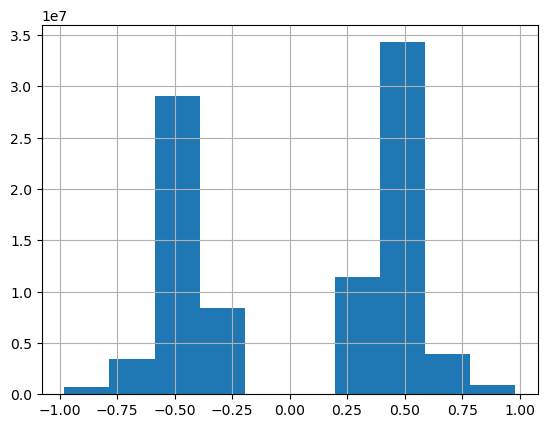

In [68]:
himorna_peaks["corr"].hist()# данные уже отфильтрованы

In [87]:
def indexing_himorna(hm, lnc_ens, subdf):
    to_index = HIMORNA_INDEX / hm
    to_index.mkdir(exist_ok=True, parents=True)
    to_save = to_index / f"{hm}-{lnc_ens}-.tsv.gz"
    subdf.to_csv(to_save, sep="\t", compression="gzip", index=False)    

In [88]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_himorna)(hm, lnc_ens, subdf)
        for (hm, lnc_ens), subdf in himorna_peaks.groupby(by=["hm", "lnc_ens"])
    )

In [5]:
to_ips = IPS / "EdgeR.table.all.target.tsv.gz"
ips_expr = pd.read_csv(to_ips, sep="\t")
ips_expr.head()

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC
0,CATG00000000155,CATG00000000155.1,0.257141,3.591144,0.550588,1.0,0.620927,G0234787_01,ENSG00000234787,LINC00458
1,CATG00000001164,CATG00000001164.1,0.706131,3.805757,0.044323,1.0,1.757448,G0234787_01,ENSG00000234787,LINC00458
2,CATG00000001318,CATG00000001318.1,-0.074655,4.766566,0.913694,1.0,0.052701,G0234787_01,ENSG00000234787,LINC00458
3,CATG00000002817,CATG00000002817.1,-0.201767,3.841792,0.716487,1.0,-0.414103,G0234787_01,ENSG00000234787,LINC00458
4,CATG00000003248,CATG00000003248.1,-0.155609,4.592817,0.650460,1.0,0.026003,G0234787_01,ENSG00000234787,LINC00458


In [7]:
ips_expr.shape

(3445156, 10)

In [6]:
ips_expr_filt = ips_expr[(((ips_expr["EdgeR.log2FC"] < 0.5) & (ips_expr["EdgeR.Zscore"] < -1.64)) | 
                                ((ips_expr["EdgeR.log2FC"] > 0.5) & (ips_expr["EdgeR.Zscore"] > 1.64))) & 
                                (ips_expr["EdgeR.FDR"] < 0.05)]
ips_expr_filt.reset_index(inplace=True, drop=True)
ips_expr_filt.head()       

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC
0,ENSG00000205531,NAP1L4,-0.691972,7.349218,3.899614e-06,0.042455,-5.061144,G0234787_08,ENSG00000234787,LINC00458
1,ENSG00000089916,GPATCH2L,-1.041246,5.600935,3.913478e-05,0.043336,-3.953852,R0057746_03,CATG00000070943,CATG00000070943.1
2,ENSG00000099194,SCD,-0.635000,8.662415,2.054724e-07,0.000870,-2.709444,R0057746_03,CATG00000070943,CATG00000070943.1
3,ENSG00000113161,HMGCR,-0.912822,6.861125,1.601495e-05,0.029059,-3.682696,R0057746_03,CATG00000070943,CATG00000070943.1
4,ENSG00000128829,EIF2AK4,-0.887877,6.605389,2.397361e-07,0.000870,-4.709886,R0057746_03,CATG00000070943,CATG00000070943.1


In [8]:
ips_expr_filt.shape

(16294, 10)

In [ ]:
for key, subdf in ips_expr_filt.groupby(by=["target.geneID", "target.gapmerID"]):
    print(key, subdf.shape[0])

In [85]:
def indexing_deg(lnc_ens, aso, subdf):
    to_index = IPS_INDEX / lnc_ens
    to_index.mkdir(exist_ok=True, parents=True)
    to_save = to_index / f"{lnc_ens}-{aso}-.tsv.gz"
    subdf.to_csv(to_save, sep="\t", compression="gzip", index=False)    

In [86]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_deg)(lnc_ens, aso, subdf)
        for (lnc_ens, aso), subdf in ips_expr_filt.groupby(by=["target.geneID", "target.gapmerID"])
    )

In [13]:
fantom_lv2 = pd.read_csv(FANTOM / "FANTOM_CAT.lv2_permissive.info_table.gene.tsv.gz", sep="\t")

In [279]:
fantom_lv2_mapping = fantom_lv2[["geneID_without_v", "geneName"]].set_index("geneID_without_v")

In [61]:
%%time
deg_gene_ids = set(subdf["DEG.geneID"])
deg_mask = fantom_lv2["geneID"].apply(lambda x: x.split(".")[0] in deg_gene_ids)

CPU times: user 59.9 ms, sys: 0 ns, total: 59.9 ms
Wall time: 58.6 ms


In [230]:
def create_matrix(to_deg, to_himorna):
    deg_gene_ids = np.asarray(pd.read_csv(to_deg, sep="\t", usecols=["DEG.geneID"])["DEG.geneID"])
    corr_gene_ids = np.asarray(pd.read_csv(to_himorna, sep="\t", usecols=["gene_ens"])["gene_ens"])
    
    deg_mask = fantom_lv2["geneID_without_v"].isin(deg_gene_ids)
    corr_mask = fantom_lv2["geneID_without_v"].isin(corr_gene_ids)
    TP = deg_mask & corr_mask
    TN = deg_mask & ~corr_mask
    FP = ~deg_mask & corr_mask
    FN = ~(deg_mask | corr_mask)
    
    to_save = MATRICES / to_himorna.name.split('-')[0] / f"{to_himorna.name.split('-')[1]}-{to_deg.name.split('-')[1]}-.npy"
    if to_save.exists():
        print(f"Skipped: ({to_himorna.name.split('-')[0]}) {to_himorna.name.split('-')[1]} {to_deg.name.split('-')[1]}")
        return
    to_save.parent.mkdir(exist_ok=True, parents=True)
    np.save(to_save, np.stack((TP, TN, FP, FN)))

def create_matrix_1(to_deg, to_himorna):
    deg_gene_ids = pd.read_csv(to_deg, sep="\t", usecols=["DEG.geneID"])["DEG.geneID"]
    corr_gene_ids = pd.read_csv(to_himorna, sep="\t", usecols=["gene_ens"])["gene_ens"]
    
    deg_mask = np.asarray(fantom_lv2["geneID"].apply(lambda x: x.split(".")[0] in deg_gene_ids))
    corr_mask = np.asarray(fantom_lv2["geneID"].apply(lambda x: x.split(".")[0] in corr_gene_ids))
    TP = deg_mask & corr_mask
    TN = deg_mask & ~corr_mask
    FP = ~deg_mask & corr_mask
    FN = ~(deg_mask | corr_mask)
    return [TP, TN, FP, FN]
        
def create_matrix_2(to_deg, to_himorna):
    deg_gene_ids = pd.read_csv(to_deg, sep="\t", usecols=["DEG.geneID"])["DEG.geneID"]
    corr_gene_ids = pd.read_csv(to_himorna, sep="\t", usecols=["gene_ens"])["gene_ens"]
    
    deg_mask = np.asarray(fantom_lv2["geneID"].apply(lambda x: x.split(".")[0] in deg_gene_ids))
    corr_mask = np.asarray(fantom_lv2["geneID"].apply(lambda x: x.split(".")[0] in corr_gene_ids))
    TP = np.logical_and(deg_mask, corr_mask)
    TN = np.logical_xor(deg_mask, corr_mask)
    FP = np.logical_xor(corr_mask, deg_mask)
    FN = np.logical_not(np.logical_or(corr_mask, deg_mask))
    return [TP, TN, FP, FN]

def create_matrix_3(to_deg, to_himorna):
    deg_gene_ids = np.asarray(pd.read_csv(to_deg, sep="\t", usecols=["DEG.geneID"])["DEG.geneID"])
    corr_gene_ids = np.asarray(pd.read_csv(to_himorna, sep="\t", usecols=["gene_ens"])["gene_ens"])
    
    deg_mask = fantom_lv2["geneID_without_v"].isin(deg_gene_ids)
    corr_mask = fantom_lv2["geneID_without_v"].isin(corr_gene_ids)
    TP = deg_mask & corr_mask
    TN = deg_mask & ~corr_mask
    FP = ~deg_mask & corr_mask
    FN = ~(deg_mask | corr_mask)
    return np.stack((TP, TN, FP, FN))

In [231]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(create_matrix)(to_deg, to_himorna)
        for to_deg in IPS_INDEX.glob(('*/*.tsv.gz')) for to_himorna in HIMORNA_INDEX.glob((f'*/*-{to_deg.name.split("-")[0]}-.tsv.gz'))
    )

with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(create_matrix)(to_deg, to_himorna)
        for to_deg in IPS_INDEX.glob(('*/*.tsv.gz')) for to_himorna in HIMORNA_INDEX.glob(('*/*.tsv.gz'))
    )

deg_gene_ids = pd.read_csv(IPS_INDEX / "ENSG00000196668" / "ENSG00000196668-G0196668_02-.tsv.gz", sep="\t")
corr_gene_ids = pd.read_csv(HIMORNA_INDEX / "H3K4me3" / "H3K4me3-ENSG00000196668-.tsv.gz", sep="\t")

fantom_lv2["geneID_without_v"] = fantom_lv2["geneID"].apply(lambda x: x.split(".")[0])

%%time
[np.sum(create_matrix_1(IPS_INDEX / "ENSG00000196668" / "ENSG00000196668-G0196668_02-.tsv.gz", HIMORNA_INDEX / "H3K4me3" / "H3K4me3-ENSG00000196668-.tsv.gz")) for i in range(10)]

%%time
[np.sum(create_matrix_1(IPS_INDEX / "ENSG00000196668" / "ENSG00000196668-G0196668_02-.tsv.gz", HIMORNA_INDEX / "H3K4me3" / "H3K4me3-ENSG00000196668-.tsv.gz")) for i in range(10)]

%%time
[np.sum(create_matrix_2(IPS_INDEX / "ENSG00000196668" / "ENSG00000196668-G0196668_02-.tsv.gz", HIMORNA_INDEX / "H3K4me3" / "H3K4me3-ENSG00000196668-.tsv.gz")) for i in range(10)]

%%time
[np.sum(create_matrix_3(IPS_INDEX / "ENSG00000196668" / "ENSG00000196668-G0196668_02-.tsv.gz", HIMORNA_INDEX / "H3K4me3" / "H3K4me3-ENSG00000196668-.tsv.gz")) for i in range(10)]

create_matrix_3(IPS_INDEX / "ENSG00000196668" / "ENSG00000196668-G0196668_02-.tsv.gz", HIMORNA_INDEX / "H3K4me3" / "H3K4me3-ENSG00000196668-.tsv.gz")

In [228]:
def fisher_exact_test(to_matrice):
    matrice = np.sum(np.load(to_matrice), axis=1)
    fisher_exact_res = fisher_exact([[matrice[0], matrice[1]], 
                         [matrice[2], matrice[3]]], alternative='two-sided')
    return fisher_exact_res[1]
    #return matrice

In [227]:
fisher_exact_test(MATRICES / "H3K27ac" / "ENSG00000233184-G0233184_04-.npy")

array([     0,    128,      7, 124110])

In [251]:
def job(hm):
    p_values = []
    lncrna = []
    aso = []
    for to_matrice in (MATRICES / hm).glob('*'):
        p_values.append(fisher_exact_test(to_matrice))
        lncrna.append(to_matrice.name.split("-")[0])
        aso.append(to_matrice.name.split("-")[1])
    df = pd.DataFrame({"hm": [hm for i in range(len(p_values))],
                       "lnc_ens": lncrna,
                       "aso": aso,
                       "p_value": p_values})
    p_value_adj_bonf = multipletests(df["p_value"], method='bonferroni', is_sorted=False, returnsorted=False)[1]
    df['p_value_adj_bonf'] = p_value_adj_bonf
    to_save = FISHER / f"{hm}.tsv"
    if to_save.exists():
        print(f"Skipped: {hm}")
        return
    to_save.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(to_save, sep="\t", index=False)

In [254]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(job)(hm.name)
        for hm in MATRICES.iterdir())

In [256]:
fisher_results = {to_df.stem: pd.read_csv(to_df ,sep="\t") for to_df in FISHER.glob("*.tsv")}

In [267]:
treshold_p_value = 0.05
fisher_results_filt = []
for hm in fisher_results:
    fisher_results_filt.append(fisher_results[hm].query(f"p_value_adj_bonf < {treshold_p_value}").reset_index(drop=True))
fisher_results_filt = pd.concat(fisher_results_filt).reset_index(drop=True)

In [281]:
fisher_results_filt["lnc"] = fisher_results_filt["lnc_ens"].apply(lambda x: fantom_lv2_mapping.loc[x, "geneName"])

In [284]:
fisher_results_filt.sort_values(by=["lnc", "p_value_adj_bonf"])

,hm,lnc_ens,aso,p_value,p_value_adj_bonf,lnc
5,H3K4me2,ENSG00000235560,G0235560_01,2.803825e-10,1.878562e-08,AC002310.12
8,H3K4me2,ENSG00000235560,G0235560_03,3.290078e-06,2.204352e-04,AC002310.12
20,H3K27ac,ENSG00000227403,G0227403_04,1.793569e-04,1.381048e-02,AC009299.3
30,H3K4me1,ENSG00000227403,G0227403_04,1.557503e-04,1.386178e-02,AC009299.3
23,H3K27ac,ENSG00000212978,G0212978_03,1.335501e-04,1.028335e-02,AC016747.3
16,H3K4me3,ENSG00000212978,G0212978_03,2.382738e-04,2.430393e-02,AC016747.3
13,H3K4me3,ENSG00000225975,G0225975_05,2.575401e-04,2.626909e-02,AC074138.3
26,H3K9ac,ENSG00000245937,G0245937_01,2.845680e-04,1.622037e-02,CTC-228N24.3
17,H3K4me3,ENSG00000245937,G0245937_01,1.844638e-04,1.881531e-02,CTC-228N24.3
10,H3K4me2,ENSG00000249042,G0249042_08,4.591768e-08,3.076485e-06,CTD-2015H6.3
